# Vaccination Tweets: EDA, Sentiment Analyis

Agenda:
+ Frequency
    + most frequent words in tweets
    + look at most popular hashtags (in 'text' and in 'hashtags')
    + what is the most tweeted-about vaccine?
+ Time
    + Which vaccine "trends" in tweets? (time series)
    + Do different vaccines trend at different times as tweet subjects?

+ Sentiment
    + vaccine most closely connected to negative/positive sentiment
    + most influential sources who tweet positive/negative/neutral about vaccines in general
    + locations (uncleared) with the most positive, negative, neutral tweets
    + Positive, negative, neutral: which gets more retweets / are liked more?

(Measuring general attitude via tweets: how many people tweet by population, how many by population tweet about vaccines, how well are vaccinations monitored)

In [357]:
# Main data packages. 
import numpy as np
import pandas as pd
from datetime import datetime

#NLP modules
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

#sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [93]:
#nltk.download('punkt')
#nltk.download('wordnet')

In [305]:
df = pd.read_csv("Data/vaccination_tweets.csv")

In [306]:
df_tweety = df.copy()

In [307]:
shape = df_tweety.shape
print('The unmodified vaccination tweets dataset contains {} columns and {} rows.'.format(shape[1], shape[0]))

The unmodified vaccination tweets dataset contains 16 columns and 38547 rows.


In [308]:
#df_tweety.head()

In [309]:
df_tweety.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38547 entries, 0 to 38546
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                38547 non-null  int64 
 1   user_name         38547 non-null  object
 2   user_location     29767 non-null  object
 3   user_description  35940 non-null  object
 4   user_created      38547 non-null  object
 5   user_followers    38547 non-null  int64 
 6   user_friends      38547 non-null  int64 
 7   user_favourites   38547 non-null  int64 
 8   user_verified     38547 non-null  bool  
 9   date              38547 non-null  object
 10  text              38547 non-null  object
 11  hashtags          30330 non-null  object
 12  source            38514 non-null  object
 13  retweets          38547 non-null  int64 
 14  favorites         38547 non-null  int64 
 15  is_retweet        38547 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 4.2+ MB


In [310]:
df_tweety.describe().round(2)

,id,user_followers,user_friends,user_favourites,retweets,favorites
count,3.854700e+04,38547.00,38547.00,38547.00,38547.00,38547.00
mean,1.365051e+18,109675.74,1309.57,15013.42,3.11,13.75
std,8.619936e+15,882398.75,6020.04,41677.98,33.87,184.20
min,1.337728e+18,0.00,0.00,0.00,0.00,0.00
25%,1.362003e+18,120.00,144.00,360.00,0.00,0.00
50%,1.366887e+18,577.00,417.00,2146.00,0.00,1.00
75%,1.371547e+18,2780.50,1189.00,11272.00,1.00,4.00
max,1.375348e+18,14906907.00,380428.00,1205878.00,2360.00,22815.00


In [311]:
df_tweety.isnull().sum()

id                     0
user_name              0
user_location       8780
user_description    2607
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            8217
source                33
retweets               0
favorites              0
is_retweet             0
dtype: int64

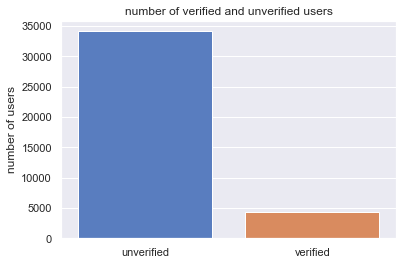

From 38547 accounts, 11.37% are verified twitter accounts.


In [312]:
sns.set_theme()
sns.set_palette('muted')
#Print users (verified/unverified), "verified" meaning that they are recognized to have some sort of official character
ax = sns.countplot(x='user_verified', data=df_tweety)
ax.set(xlabel='', ylabel='number of users', title='number of verified and unverified users')
plt.xticks(ticks=[False,True], labels=['unverified','verified'])
plt.show()
print(f'From {df_tweety.shape[0]} accounts, {round(df_tweety.user_verified.mean()*100, 2)}% are verified twitter accounts.')

In [313]:
#No tweets in this dataset appear to be retweets
df_tweety["is_retweet"].unique()

array([False])

In [314]:
#Insert column 'day' to map the vaccination progress data set
df_tweety['day'] = pd.to_datetime(df_tweety.date).dt.date

In [315]:
df_tweety.dtypes

id                   int64
user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
retweets             int64
favorites            int64
is_retweet            bool
day                 object
dtype: object

## Dropping stuff(?)

In [316]:
#'user_location' is a highly diverse category
df_tweety.user_location.nunique()

8098

In [317]:
#The below mentioned columns should be dropped
df_tweety.drop(['id', 'user_created', 'user_location', 'is_retweet', 'source'], axis=1)

,user_name,user_description,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,retweets,favorites,day
0,Rachel Roh,Aggregator of Asian American news; scanning di...,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],0,0,2020-12-20
1,Albert Fong,"Marketing dude, tech geek, heavy metal & '80s ...",834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,1,1,2020-12-13
2,eli🇱🇹🇪🇺👌,"heil, hydra 🖐☺",10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",0,0,2020-12-12
3,Charles Adler,"Hosting ""CharlesAdlerTonight"" Global News Radi...",49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,446,2129,2020-12-12
4,Citizen News Channel,Citizen News Channel bringing you an alternati...,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",0,0,2020-12-12
...,...,...,...,...,...,...,...,...,...,...,...,...
38542,Rising Bharat,Bharat is Rising,625,0,0,False,2021-03-18 06:22:41,The Sputnik V is under review for emergency us...,NaN,1,7,2021-03-18
38543,Bright Uzbekistan,Bright Uzbekistan is a new International magaz...,18,182,59,False,2021-03-18 06:13:08,IT IS PLANNED TO START MASS VACCINATION IN UZB...,NaN,0,0,2021-03-18
38544,Sputnik V,Sputnik V is the world’s first registered COVI...,223700,142,678,True,2021-03-18 06:01:50,Austrian Chancellor Sebastian Kurz: Concerning...,['SputnikV'],83,226,2021-03-18
38545,Sputnik,"Sputnik is a global wire, radio and digital ne...",322326,306,24,True,2021-03-18 05:30:00,Norwegian politicians calling to cut #SputnikV...,['SputnikV'],6,16,2021-03-18


In [318]:
#There are duplicates in the text section, however, they ... check if source identical, there are no retweets, maybe duplicates should be removed in order to prevent imbalance
#df_tweety[(df_tweety.duplicated(subset=['text', 'user_name'], keep=False))]

In [319]:
#create dataframes for subcategories
#df = df_tweety[(df_tweety["user_followers"]>=10)]# & (df_tweety["user_verified"]==True)] (df_tweety["user_followers"]>=10)

In [320]:
# Users tweet repeptitively. About a third of users tweet repetitively. Assuming that their sentiment does not change, their sentiment is amplified.
(len(df_tweety) - df_tweety.user_name.nunique())/len(df_tweety)

0.4389187225983864

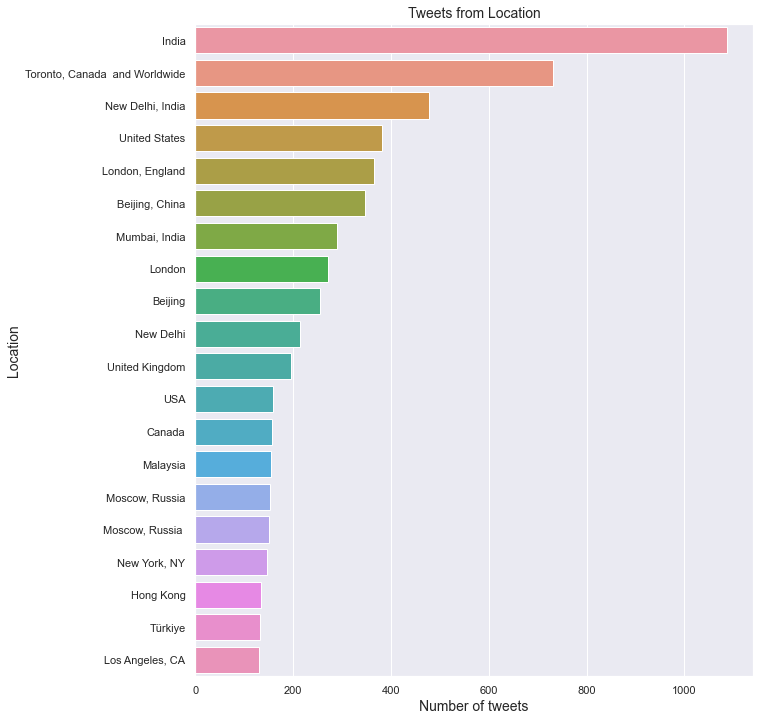

In [360]:
#user_location columns is very diverse
plt.figure(figsize=(10,12))
sns.barplot(df_tweety["user_location"].value_counts().values[0:20],
            df_tweety["user_location"].value_counts().index[0:20]);
plt.title("Tweets from Location",fontsize=14)
plt.xlabel("Number of tweets",fontsize=14)
plt.ylabel("Location",fontsize=14)
plt.show()

# Frequent words and hashtags

### A look at the most popular tweets

In [361]:
# Total tweets
print('Total tweets:', len(df_tweety.index), '\n')

# Retweets
df_tweety_stat = df.sort_values(by='retweets', ascending=False)
print('Mean retweets:', round(df_tweety_stat['retweets'].mean(),2), '\n')

print('10 most responded tweets')
print('------------------------')
print(df_tweety['text'].iloc[:10], '\n')
    
# Likes
df_tweety_stat = df.sort_values(by='user_favourites', ascending=False)
print('Mean likes:', round(df_tweety_stat['user_favourites'].mean(),2), '\n')
print('10 most liked tweets')
print('--------------------')
print(df_tweety['text'].iloc[:10], '\n')

Total tweets: 38547 

Mean retweets: 3.11 

10 most responded tweets
------------------------
0    Same folks said daikon paste could treat cytok...
1    While world wrong side history year, hopefully...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts immutable, Senator, even ethically sturd...
4    Explain need vaccine @BorisJohnson @MattHancoc...
5    Does anyone useful advice/guidance whether COV...
6    bit sad claim fame success #vaccination patrio...
7    There many bright days 2020 best 1. #BidenHarr...
8    Covid vaccine; You getting it? #CovidVaccine #...
9    #CovidVaccine States start getting #COVID19Vac...
Name: text, dtype: object 

Mean likes: 15013.42 

10 most liked tweets
--------------------
0    Same folks said daikon paste could treat cytok...
1    While world wrong side history year, hopefully...
2    #coronavirus #SputnikV #AstraZeneca #PfizerBio...
3    Facts immutable, Senator, even ethically sturd...
4    Explain need vaccine @BorisJohnson @Ma

import requests
furl = 'https://spotleai.sgp1.digitaloceanspaces.com/course/data/tweets_bollywood.txt'
response = requests.get(furl)
tweets = response.text.split("\n")

raw = ' '.join(tweets)
tags = [re.sub(r"(\W+)$", "", j) for j in [i for i in raw.split() if i.startswith("#")]]
df_top = pd.DataFrame({"hashtag": tags})
fig, ax = plt.subplots()
plt.xlabel('Top trending Tweets')
df_top['hashtag'].value_counts().head(8).plot(ax=ax, kind='bar',figsize=(8,5))

### Most mentioned words in 'text'

In [362]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english') + ['i', 'the', 'get', '-', 'one']
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [363]:
tweet_words = []
for line in list(df_tweety['text']):
    words = line.split()
    for word in words:
        tweet_words.append(word.lower())
tweet_words=pd.Series(np.array(tweet_words))
frequency_ranking_words = tweet_words.value_counts()[:11].rename_axis('words_text_freq').reset_index(name='count')
#frequency_ranking_words

### Most frequent hashtags in 'text'

In [364]:
tweet_words_hasht = []
for line in list(df_tweety['text']):
    words = line.split()
    for word in words:
        if '#' in word:
            tweet_words_hasht.append(word.lower())
tweet_words_hasht=pd.Series(np.array(tweet_words_hasht))
frequency_hashtags = tweet_words_hasht.value_counts()[:20].rename_axis('text_hasht_freq').reset_index(name='count')
frequency_hashtags

,text_hasht_freq,count
0,#moderna,6184
1,#covaxin,4122
2,#covid19,4074
3,#pfizerbiontech,3499
4,#vaccine,3065
5,#sputnikv,2861
6,#oxfordastrazeneca,1788
7,#covidvaccine,1599
8,#pfizer,1375
9,#sinovac,1364


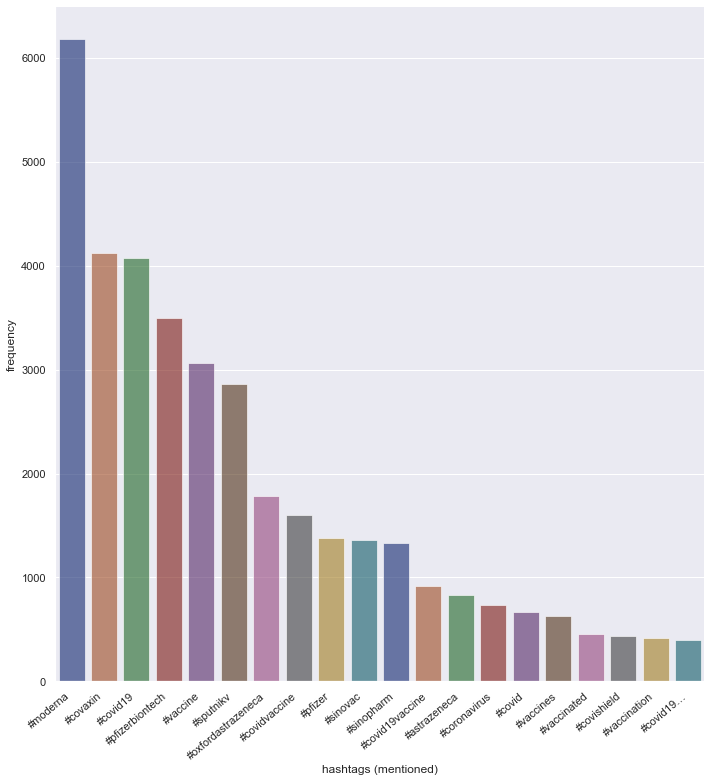

In [365]:
#f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

g = sns.catplot(
    data=frequency_hashtags, kind="bar",
    x="text_hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hashtags (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

### Most frequently mentioned twitter accounts

In [366]:
twitter_accounts = []
for line in list(df_tweety['text']):
    words = line.split()
    for word in words:
        if '@' in word:
            twitter_accounts.append(word.lower())
mentioned_accounts=pd.Series(np.array(twitter_accounts))
accounts = mentioned_accounts.value_counts()[:20].rename_axis('accounts').reset_index(name='count')
accounts

,accounts,count
0,@narendramodi,730
1,@sputnikvaccine,386
2,@bharatbiotech,376
3,@,227
4,@pmoindia,196
5,@pfizer,186
6,@potus,158
7,@fordnation,147
8,@ocugen,143
9,@who,143


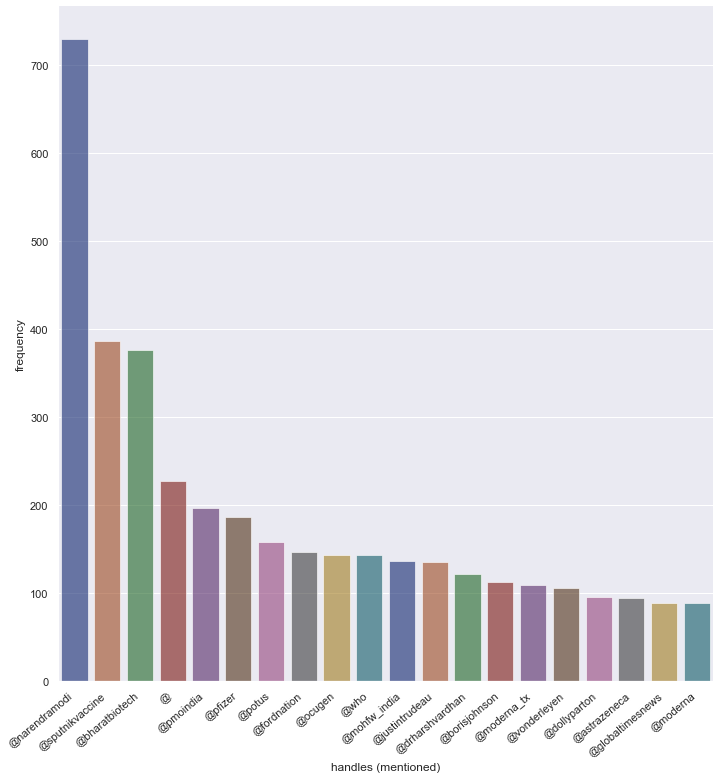

In [367]:
#f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

g = sns.catplot(
    data=accounts, kind="bar",
    x="accounts", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("handles (mentioned)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

### Most frequent hashtags in 'hashtags'

In [371]:
df_tweety['hashtags'].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                              8217
[Moderna]                                       1653
[Covaxin]                                       1511
[SputnikV]                                      1231
[PfizerBioNTech]                                 821
                                                ... 
[Britain]                                          1
[COVID19, AstraZeneca, CovidVaccines]              1
[vaccinated, CovishieldVaccine, COVAXIN]           1
[covishieldvaccine, covaxin, COVID19Vaccine]       1
[Covid19, Vaccine, PfizerBioNTech]                 1
Name: hashtags, Length: 14361, dtype: int64

Lists in 'hashtags' are stored as strings

In [369]:
#for i, l in enumerate(df_tweety['hashtags']):
 #   print("list",i,"is",type(l))

In [370]:
df_tweety['hashtags'] = df_tweety['hashtags'].apply(eval)

TypeError: eval() arg 1 must be a string, bytes or code object

In [336]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x for lst in Series for x in lst])

hasht_freq = to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_freq').reset_index(name='count')
hasht_freq

,hasht_freq,count
0,Moderna,5717
1,COVID19,3917
2,Covaxin,3671
3,SputnikV,3253
4,PfizerBioNTech,3191
5,vaccine,3073
6,Pfizer,1564
7,Sinopharm,1459
8,Sinovac,1433
9,CovidVaccine,1402


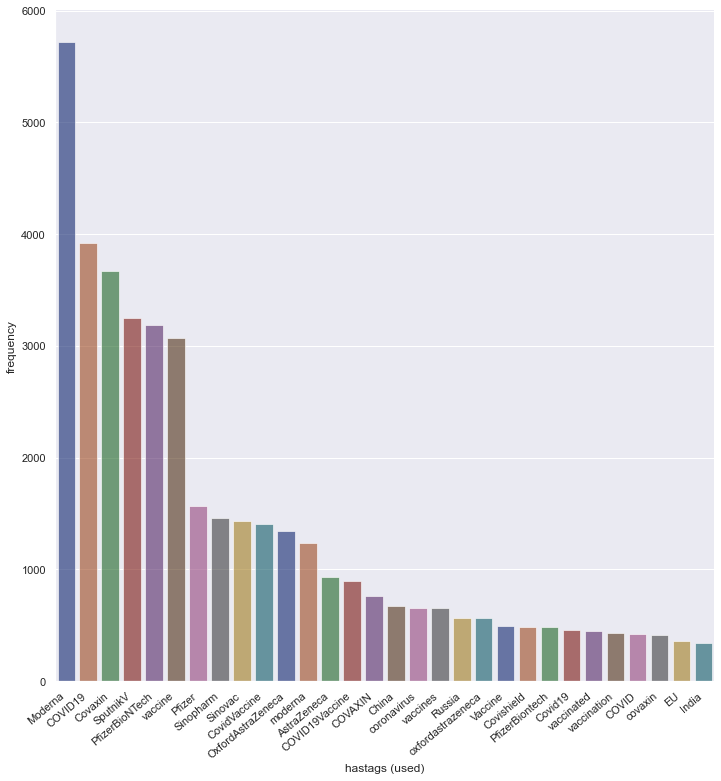

In [346]:
#f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

g = sns.catplot(
    data=hasht_freq, kind="bar",
    x="hasht_freq", y="count",# hue="sex",
    ci="sd", palette="dark", height=10, alpha=.6
)
#g.despine(left=True)
g.set_axis_labels("hastags (used)", "frequency")
g.set_xticklabels(rotation=40, ha="right")
#g.legend.set_title("")

### Most mentioned countries in 'hashtags'
China, Russia and EU are tweeted about by far the most.

In [341]:
df_tweety['hashtags'] = df_tweety['hashtags'].fillna('[]')

def to_1D(Series):
    return pd.Series([x for lst in Series for x in lst if x in ['China', 'EU', 'USA', 'Russia', 'UK', 'Italy', 'Germany', 'France', 'America', 'Brazil', 'Japan', 'Canada', 'Afghanistan', 'china']])

to_1D(df_tweety['hashtags']).value_counts()[:30].rename_axis('hasht_country_freq').reset_index(name='count')

,hasht_country_freq,count
0,China,670
1,Russia,568
2,EU,361
3,Italy,97
4,Canada,94
5,UK,92
6,USA,70
7,Brazil,68
8,Germany,65
9,France,25


### overtweeted (one tweet several times)

In [356]:
repeated_tweets = []
for i in range(len(df_tweety['text'])):
    repeated_tweets.append(df_tweety['text'][i])
repeated_tweets=pd.Series(np.array(repeated_tweets))
#list_of_words

frequency_ranking_tweets = repeated_tweets.value_counts()[:30].rename_axis('overtweeted').reset_index(name='count')
#frequency_ranking_tweets

### Create df with hashtags as columns and boolean values

Idea: create df with vaccines in hashtags as columns and append it to df_tweety

In [144]:
def to_1D(Series):
    return pd.Series([x for lst in Series for x in lst])

unique_hasht = to_1D(df_tweety['hashtags']).value_counts()[:20]

In [145]:
def boolean_df(item_lists, unique_items):

    # Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask that returns a True-False list of whether a tag is in a taglist
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [146]:
hasht_bool = boolean_df(df_tweety['hashtags'], unique_hasht.keys())

In [147]:
hasht_bool

,Moderna,COVID19,Covaxin,SputnikV,PfizerBioNTech,vaccine,Pfizer,Sinopharm,Sinovac,CovidVaccine,OxfordAstraZeneca,moderna,AstraZeneca,COVID19Vaccine,COVAXIN,China,coronavirus,vaccines,Russia,oxfordastrazeneca
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38542,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
38543,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
38544,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
38545,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Cleaning 'text'

### Various removals, lowercase()

def CleanTweet(x):
    #remove twitter handlers
    x = re.sub('@[^\s]+','',x)
    #remove hashtags
    x = re.sub(r'\B#\S+','',x)
    #remove urls
    x = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x)
    #remove special characters
    x = re.findall(r'\w+', x)
    #remove single characters
    x = re.sub(r'\s+[a-zA-Z]\s+', '', x)
    #substitute multiple spaces with single space
    x = re.sub(r'\s+', ' ', x, flags=re.I)
    return x

In [131]:
#df_tweety.text = df_tweety.text.apply(CleanTweet)

In [132]:
#remove twitter handlers
df_tweety.text = df_tweety.text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#remove URLs
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', x))

#remove punctuation
df_tweety.text = df_tweety.text.apply(lambda x:x.replace('[^\w\s]',''))

#remove special characters
df_tweety.text = df_tweety.text.apply(lambda x:' '.join(re.findall(r'\w+', x))) #re.sub('[^A-Za-z0-9]+', '', x)

#remove single characters
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#substitute multiple spaces with single space
df_tweety.text = df_tweety.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

#lowercase
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word.lower() for word in x.split()]))

# Feature engineering 'text'

### stopwords, stemming, lemmatizing

In [133]:
#remove stopwords
stopwords = nltk.corpus.stopwords.words('english')
df_tweety.text = df_tweety.text.apply(lambda x:' '.join([word for word in x.split() if word not in stopwords]))

In [134]:
#tokenize
#df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([word_tokenize(word) for word in x.split() ]))

In [135]:
# stemming 
stemmer = PorterStemmer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [136]:
# lemmazation
lemmatizer = WordNetLemmatizer()
df_tweety.text = df_tweety.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() ]))

Try to turn abbreviations into regular strings

In [137]:
import csv

#helper function to turn abbreviations into words and delete slang
def translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
        # File path which consists of Abbreviations.
        fileName = "/Users/JDSeo/Desktop/Daily-Neural-Network-Practice-2/NLP/cleaning/slang.txt"
        with open(fileName, "r") as myCSVfile:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            dataFromFile = csv.reader(myCSVfile, delimiter="=")
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9]+', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            myCSVfile.close()
        j = j + 1
    return ' '.join(user_string)

# Create some sub-dataframes

### single out most popular users and their tweets (and tweet sentiments)

In [349]:
df_tweety.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet', 'day'],
      dtype='object')

In [350]:
#popular users will be found in 'user_verified'
df_verified = df_tweety[df_tweety['user_verified']==True]

In [351]:
df_verified.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,day
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts immutable, Senator, even ethically sturd...",[],Twitter Web App,446,2129,False,2020-12-12
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There many bright days 2020 best 1. #BidenHarr...,"[BidenHarris, Election2020]",Twitter for iPhone,2,22,False,2020-12-12
12,1337815730486702087,WION,India,#WION: World Is One | Welcome to India’s first...,2016-03-21 03:44:54,292510,91,7531,True,2020-12-12 17:45:00,The agency also released new information healt...,[],TweetDeck,0,18,False,2020-12-12
13,1337809196453081088,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emergin...",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 17:19:02,For women healthcare providers asking safety #...,[PfizerBioNTech],Twitter for iPhone,48,82,False,2020-12-12
15,1337789467038523394,City A.M.,"London, England","London's business newspaper - News, Opinion, a...",2009-06-09 13:53:06,66224,603,771,True,2020-12-12 16:00:38,Trump announces #vaccine rollout 'in less 24 h...,[vaccine],Twitter for iPhone,0,1,False,2020-12-12


In [352]:
df_verified.shape

(4382, 17)

In [353]:
df_twinfluence = df_verified.groupby(['favorites']).count()

In [355]:
df_twinfluence

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,is_retweet,day
favorites,,,,,,,,,,,,,,,,
0,405,405,377,405,405,405,405,405,405,405,405,405,405,405,405,405
1,449,449,436,449,449,449,449,449,449,449,449,449,449,449,449,449
2,356,356,327,356,356,356,356,356,356,356,356,356,356,356,356,356
3,288,288,271,287,288,288,288,288,288,288,288,288,288,288,288,288
4,251,251,215,251,251,251,251,251,251,251,251,251,251,251,251,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
5575,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5827,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [200]:
from matplotlib import rcParams

In [207]:
#popular = df_tweety.sort_values("user_followers", ascending=False)[['user_name', 'user_followers']][:10]

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

In [246]:
data = df_tweety.sort_values("user_followers", ascending=False)

In [247]:
data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,day
36459,1374276683893600260,NDTV,India,Breaking news alerts from India.\n\nInstagram:...,2009-05-01 20:34:48,14906907,15,0,True,2021-03-23 08:27:48,blood clot risk top govern panel ndtvsukirti d...,"[Covishield, Covaxin]",Twitter Media Studio - LiveCut,5,34,False,2021-03-23
36471,1374259361267118083,NDTV,India,Breaking news alerts from India.\n\nInstagram:...,2009-05-01 20:34:48,14906907,15,0,True,2021-03-23 07:18:58,blood clot risk top govern panel,"[Covishield, Covaxin]",NDTV News Studio,8,80,False,2021-03-23
25774,1369931563157266436,NDTV,India,Breaking news alerts from India.\n\nInstagram:...,2009-05-01 20:34:48,14879495,15,0,True,2021-03-11 08:41:51,coronaviru public peer review process take tim...,[FactsVsMyths],Twitter Media Studio - LiveCut,11,55,False,2021-03-11
25905,1369657171143618561,NDTV,India,Breaking news alerts from India.\n\nInstagram:...,2009-05-01 20:34:48,14879493,15,0,True,2021-03-10 14:31:31,taken clinic trial mode expert panel recommend...,[Covaxin],Twitter Media Studio - LiveCut,9,43,False,2021-03-10
24249,1369223067130490882,NDTV,India,Breaking news alerts from India.\n\nInstagram:...,2009-05-01 20:34:48,14873025,15,0,True,2021-03-09 09:46:32,dr anita ramesh chandra clinic trial specialis...,[Covaxin],Twitter Media Studio - LiveCut,2,39,False,2021-03-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1342002312898899969,sliceandbites,NaN,"Hello Sweeties, \n\nWelcome to @SliceandBites!...",2020-11-08 16:51:36,0,30,0,False,2020-12-24 07:00:59,thank god vaccin arriv power,"[Emirates, PfizerBioNTech]",Twitter Web App,0,0,False,2020-12-24
25943,1371361723169570817,The His In Histamine,NaN,I hate people. I am toxic.,2021-02-16 06:03:15,0,20,13,False,2021-03-15 07:24:48,sputnikcovid vaccin develop gamaleya nation re...,[],Twitter Web App,0,0,False,2021-03-15
30359,1371811999206805506,Raftarshenas,NaN,رفتارشناس نیستم. فالو میکنم ببینم افکارت چطوری...,2021-02-08 19:43:33,0,0,5,False,2021-03-16 13:14:02,base data vaer belong hh 691 peopl receiv,"[Pfizer, moderna]",Twitter Web App,0,0,False,2021-03-16
16306,1365876533202735105,WD Fordy,On Twitter or Someplace Online,Bio Schmio. 🔨💊🍪🐶🎱🎭🏥🎨🥢🍓🐾🦖🎄🖊️📚 ...,2009-03-13 21:03:49,0,38,4779,False,2021-02-28 04:08:36,yep gif next tweet sum well,"[lightourwayhome, JandJ, Pfizer, Moderna]",Twitter Web App,0,1,False,2021-02-28


<AxesSubplot:xlabel='user_followers', ylabel='user_name'>

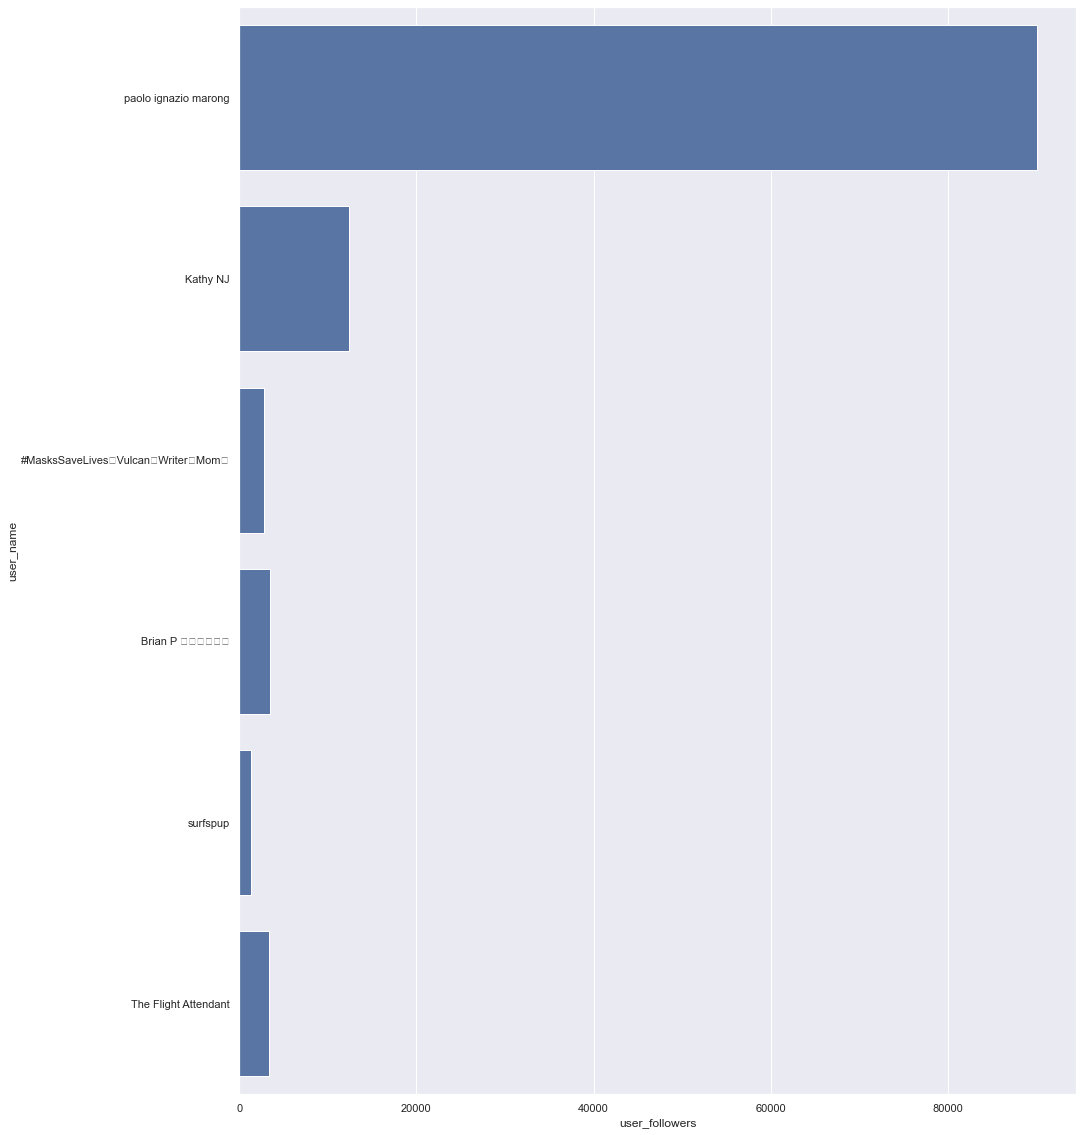

In [359]:
f, ax = plt.subplots(figsize=(15, 20))
sns.barplot(x='user_followers', y='user_name', orient='h', palette=['b'], data=data[['user_name', 'user_followers']][:10])

In [245]:
data

,user_name,user_followers
36459,NDTV,14906907
36471,NDTV,14906907
25774,NDTV,14879495
25905,NDTV,14879493
24249,NDTV,14873025
...,...,...
5386,Daily Express,873398
4479,The Daily Star,872671
4822,Daily Express,872526
4808,Daily Express,872526


In [ ]:
# delete multiples for certain purposes! Written

<AxesSubplot:xlabel='user_friends', ylabel='user_name'>

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9419 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127754 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9855 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_

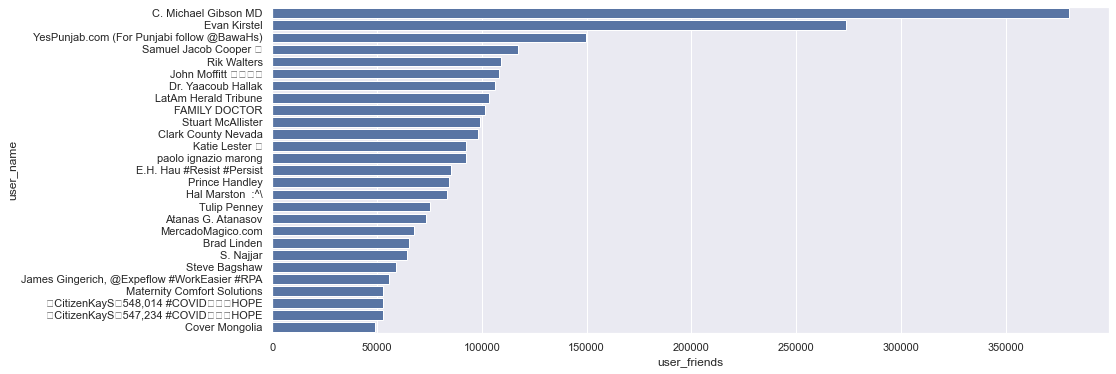

In [249]:
data = df_tweety.sort_values("user_friends", ascending=False)

f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='user_friends', y='user_name', orient='h', palette=['b'], data=data[['user_name', 'user_friends']][:50])

<AxesSubplot:xlabel='favorites', ylabel='user_name'>

/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/christophmichel/.pyenv/versions/3.8.5/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128680 missing from current font.
  font.set_text(s, 0, flags=flags)


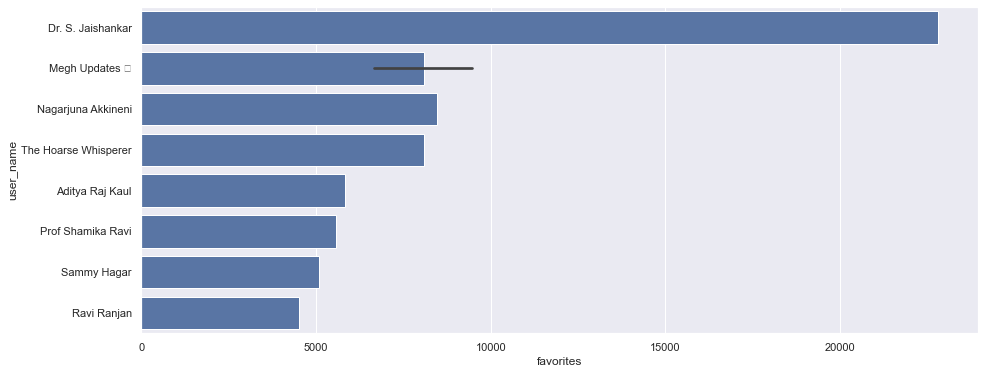

In [252]:
data = df_tweety.sort_values("favorites", ascending=False)

f, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x='favorites', y='user_name', orient='h', palette=['b'], data=data[['user_name', 'favorites']][:10])

# Sentiment analysis